In [1]:
#%matplotlib notebook  
from matplotlib import pyplot as plt
import numpy as np
import db
import pasttrec_ctrl as ptc
import json
import baseline_calib
import tdc_daq as td
import matplotlib.pyplot as plt
import time

from my_utils import *
data_dir = make_data_dir()
set_width_max_of_jupyterpad()

import ROOT



Welcome to JupyROOT 6.14/04


In [2]:
# define scan parameters:
channel_to_analyse = 4

# do not take data, but analyse existing scans: fit_only = 1
fit_only = 0

# threshold scan scurve fit quality limit to store results
chisquare_limit = 50

pktime = 15
gain = 4 
threshold_default = 10


24 boards to activate, sequence of activation, boards list: 
['0014', '0029', '0018', '0023', '0030', '0021', '0010', '0003', '0015', '0022', '0017', '0026', '0025', '0016', '0027', '0020', '0111', '0011', '0110', '0007', '0004', '0009', '0006', '0008']
next board 0014 ['0014', '0029', '0018', '0023', '0030', '0021', '0010', '0003', '0015', '0022', '0017', '0026', '0025', '0016', '0027', '0020', '0111', '0011', '0110', '0007', '0004', '0009', '0006', '0008']
board switched on:  0014
scanning keys of board: 0014
dumping data of board: 0014
board switched on:  0029
scanning keys of board: 0014
dumping data of board: 0014
board switched on:  0018
scanning keys of board: 0014
dumping data of board: 0014
board switched on:  0023
scanning keys of board: 0014
dumping data of board: 0014
board switched on:  0030
scanning keys of board: 0014
dumping data of board: 0014
board switched on:  0021
scanning keys of board: 0014
dumping data of board: 0014
board switched on:  0010
scanning keys of boa

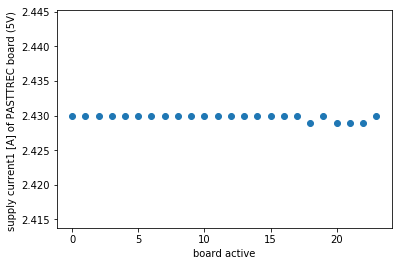

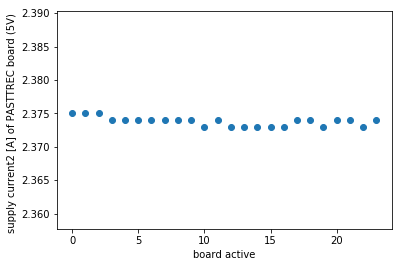

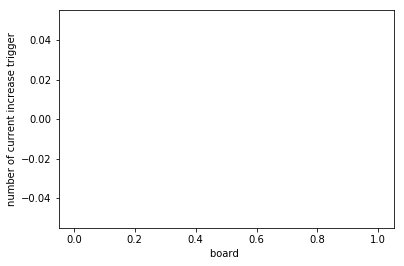

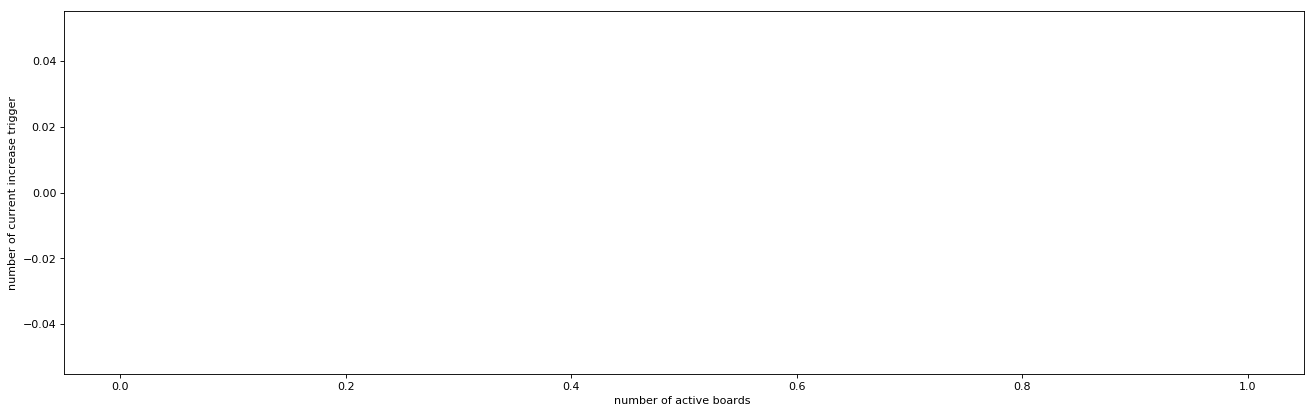

24 boards to activate, sequence of activation, boards list: 
['0021', '0010', '0014', '0029', '0030', '0003', '0018', '0015', '0023', '0022', '0017', '0026', '0025', '0016', '0027', '0020', '0111', '0011', '0110', '0007', '0004', '0009', '0006', '0008']
next board 0021 ['0021', '0010', '0014', '0029', '0030', '0003', '0018', '0015', '0023', '0022', '0017', '0026', '0025', '0016', '0027', '0020', '0111', '0011', '0110', '0007', '0004', '0009', '0006', '0008']
board switched on:  0021
scanning keys of board: 0021
dumping data of board: 0021
board switched on:  0010
scanning keys of board: 0021
dumping data of board: 0021


In [ ]:
## scan threshold of an single board as function of peaking time, gain, number of other boards switched on
# measure noise dependence:

import ROOT
import hameg_trb 

# rootMeanSquare :: [Num] -> Float
def rootMeanSquare(xs):
    return sqrt(reduce(lambda a, x: a + x * x, xs, 0) / len(xs))
def MeanArrays(xs,ys):
    return np.dot(xs,ys)/sum(ys)

# plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')

c = ROOT.TCanvas("c","The Canvas Title",640,480); c.cd();
ROOT.gStyle.SetOptFit(1)
n_wires = 162
mg = ROOT.TMultiGraph()
mg2 = ROOT.TMultiGraph()
gr = [1, 2, 3, 4]
gr2 = [1, 2, 3, 4]
filelist = []
current_list = []
volt_list = []
boards_trigger_current_list = [[],[]]
boards_trigger_number_list =  [[],[]]
index_l = 0
curr = [0,0]


import random
db.board_list_installed()
from cw_pasttrec_functions import *
for name in db.board_list_installed():
 
     ## define sequence of boards to activate in scan.
     # boards_scan_list = generate_neighbouring_FPC_board_list(name)
     boards_scan_list = generate_neighbouring_w_board_list(name)
     #  random.shuffle(boards_scan_list)
     print("next board", name,boards_scan_list)
     #start with all boards inactive     
     for my_board in db.board_list():
                db.set_standby_board(my_board)
     # start the swichting boards to active scan:
     for p in range(0,len(boards_scan_list)): 
         root_name = "/workdir/data/noise/noise_" + name + "_scan0" + str(p) + ".root"
         for i in range(0,2): 
            curr[i] =    hameg_trb.get_curr(i+3)  
         filelist += [root_name]
         if fit_only != 1:
        # switch on on board after another (unset standby):
            for my_board in db.board_list():
                if my_board == boards_scan_list[p]:
                    db.unset_standby_board(my_board)
            db.unset_standby_board(name)
            td.enable_tdc_channels_of_active_boards()
            ptc.init_active_boards(pktime,gain,threshold_default)
        
            print("board switched on: ", boards_scan_list[p])
               
            current_list += [ hameg_trb.get_curr(3) ]
            volt_list += [ hameg_trb.get_curr(4) ]
            for i in range(0,2): 
              if abs(hameg_trb.get_curr(i+3) - curr[i]) > 0.02:
                boards_trigger_current_list[i] += [boards_scan_list[p]]
                boards_trigger_number_list[i] += [p]
                print("board switched on at current change: ", i, p , boards_scan_list[p],curr[i], hameg_trb.get_curr(i+3))
       
#             baselines_set = [ 15 ] * 16
#            baseline_calib.set_baselines_individual(name,baselines_set)
            baseline_calib.char_noise_by_thresh_scan(name,dummy_calib=True)
            db.dump_db_to_root_board(root_name,name)
        #end of switch on scan loop
     #end of all boards to scan loop
     plt.scatter(range(0,len(current_list)),current_list)
     plt.xlabel("board active")
     plt.ylabel("supply current1 [A] of PASTTREC board (5V) ")
     plt.show()

     plt.scatter(range(0,len(volt_list)),volt_list)
     plt.xlabel("board active")
     plt.ylabel("supply current2 [A] of PASTTREC board (5V)  ")
     plt.show()

     for i in range(0,2):
         plt.hist(boards_trigger_current_list[i], len(boards_scan_list) )
         plt.xlabel("board ")
         plt.ylabel("number of current increase trigger")
     plt.show()
     plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
     for i in range(0,2):
         plt.hist(boards_trigger_number_list[i], len(boards_scan_list) )
         plt.xlabel("number of active boards ")
         plt.ylabel("number of current increase trigger")
     plt.show()


In [ ]:
# analyse/fit results noise dpendence:

gif_out_list = []
import root_fit as fit

# clear older fit plots
os.system("rm -rf {:s}/*".format("/workdir/data/noise/fit"))

for name in measure_board_list: 
    fit_dir = "/workdir/data/noise/fit/{:s}".format(name)
    os.mkdir(fit_dir)
    gif_out_list += [fit_dir]
    color_contrast_array = [1,632,600,417,800,616,401,880,807,633,634,626,797,617,618,622]
    c = ROOT.TCanvas("c","The Canvas Title",640,480); c.cd();
    ROOT.gStyle.SetOptFit(1)
    n_wires = 162
    mg = ROOT.TMultiGraph()
    mg2 = ROOT.TMultiGraph()
    mgDep = ROOT.TMultiGraph()
    legend = ROOT.TLegend(0.1,0.9,0.3,0.99);
    gr = [0]*len(filelist)
    gr2 = [0]*len(filelist)
    grDep = [0]*16
    dependency_list = []
    c = ROOT.TCanvas("c","The Canvas Title",640,480); c.cd();
    index_l = -1
    # for p in [1,2,4]:   # PASTTREC gain scan
    #for p in [1,2,4]:   # PASTTREC peakingtime scan
    gr3 = ROOT.TGraphErrors(); 
    noise_by_dependency_list = [] 
    noise_by_dependency_list_sigma = []
    noise_by_dependency_list_offset = []
    
    for index_channel in range(0,16): 
        grDep[index_channel] = ROOT.TGraphErrors(); 
        grDep[index_channel].SetMarkerStyle(3+index_channel);
        grDep[index_channel].SetMarkerColor(color_contrast_array[index_channel]); 
        grDep[index_channel].SetLineColor(color_contrast_array[index_channel]);   
    canID = 0
    for p in range(0,len(filelist)):
#    for p in range(0,22):        
        canID += 1
        cscan = ROOT.TCanvas("cscan" + str(canID),"The Canvas Title",640,480); cscan.cd();
        dependency_list += [ p ]
        root_name = "/workdir/data/noise/noise_" + name + "_scan0" + str(p) + ".root"
        print(root_name)
        f = ROOT.TFile(root_name)
        dummy_tsbl_tree = f.Get("dummy_tsbl_tree")
        index_l += 1
        gr[index_l] = ROOT.TGraphErrors(); 
    #     gr[index_l].SetMarkerStyle(3+index_l); gr[index_l].SetMarkerColor(color_contrast_array[index_l]); 
    #     gr[index_l].SetLineStyle(2); gr[index_l].SetLineColor(color_contrast_array[index_l]);
        gr2[index_l] = ROOT.TGraphErrors(); gr2[index_l].SetMarkerStyle(3+index_l);

    #     gr2[index_l].SetMarkerStyle(3+index_l); gr2[index_l].SetMarkerColor(color_contrast_array[index_l]); 
    #     gr2[index_l].SetLineStyle(2); gr2[index_l].SetLineColor(color_contrast_array[index_l]);    
        for l in range(0,6):
    #         index_l += 1
            stdev_list = []
            sigma_list = []
            mean_list = []    
            sigma_list_err = []
            mean_list_err = []  
            ipoint = 0
            for i in range(0,n_wires):
               cscan.cd() 
           #dummy_tsbl_tree.Draw("dummy_calib_tsbl_scan_raw >> raw_scan(120,-20,100)","chamber == 0 && layer == 3 && name == 0015 && board_chan == " + str(i) ,"colz")
#                ndata = dummy_tsbl_tree.Draw("dummy_calib_tsbl_scan_raw >> raw_scan(140,-10,130)","name == " + name + " && chamber == 0 && layer == " + str(l) + " && wires == " + str(i) + " && name != " + str(p) )  
               ndata = dummy_tsbl_tree.Draw("dummy_calib_tsbl_scan_raw>>raw_scan(140,-10,130)","name == " + name + " && wires == " + str(i) + " && layer == " + str(l) + " && name != " + str(p)  )
               if (ndata > 0): 
                   raw_scan = f.Get("raw_scan")
                   results = fit.fit_scurve(raw_scan,-1, chisquare_limit)
                   
                   raw_scan.DrawCopy()
                   cscan.Draw()
#                    cscan.Update()
                   fit_picture_file = fit_dir+"/noiseFit_lay" + str(l) +"_wire{:03d}_scan{:03d}".format(i,p) +".png"
#                    cscan.SaveAs(fit_picture_file)
                   gr[index_l].SetPoint(ipoint, i, np.double(results[2]))
                   gr[index_l].SetPointError(ipoint, 0, np.double(results[3]) )
                   gr2[index_l].SetPoint(ipoint, i, np.double(results[4]))
                   gr2[index_l].SetPointError(ipoint, 0, np.double(results[5]) )
                   if(ipoint == channel_to_analyse ):
#                        
                       cscan.SaveAs(fit_picture_file)
                       print("channel " + str(ipoint) + ", noise threshold half max (DAC) = {:.2f}".format(results[2]) )
                       gr3.SetPoint(p, p, np.double(results[2]))
                       gr3.SetPointError(p, 0, np.double(results[3]))
                       noise_by_dependency_list += [results[2]]
                       noise_by_dependency_list_sigma += [results[4]]
                       noise_by_dependency_list_offset += [results[6]]                        
                   grDep[ipoint].SetPoint(p, p, np.double(results[2]))
                   grDep[ipoint].SetPointError(p, 0, np.double(results[3]) )  
                   ipoint += 1

        mg.Add(gr[index_l]); gr[index_l].SetTitle("layer " + str(l) ); 
        mg2.Add(gr2[index_l]); gr2[index_l].SetTitle("layer " + str(l) );  
    for index_channel in range(0,16):   
        mgDep.Add(grDep[index_channel]); grDep[index_channel].SetTitle("wire " + str(index_channel) );  

       #legend->SetHeader("The Legend Title","C"); // option "C" allows to center the header
        legend.AddEntry(gr[index_l],"gain " + str(p),"lp")
        
    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(boards_scan_list[:len(noise_by_dependency_list)],noise_by_dependency_list,alpha=0.2,label = "{:d}".format(1))
    plt.xlabel("board active")
    plt.ylabel("noise threshold half max (DAC)")
    plt.show()
    
    plt.scatter(range(0,len(noise_by_dependency_list)),noise_by_dependency_list,alpha=0.2,label = "{:d}".format(1))
    plt.xlabel("number of board active")
    plt.ylabel("noise threshold half max  [2mV]")
    plt.show()
    plt.scatter(range(0,len(noise_by_dependency_list)),noise_by_dependency_list_sigma,alpha=0.2,label = "{:d}".format(1))
    plt.xlabel("number of board active")
    plt.ylabel("noise threshold sigma  [2mV]")
    plt.show()
    plt.scatter(range(0,len(noise_by_dependency_list)),noise_by_dependency_list_offset,alpha=0.2,label = "{:d}".format(1))
    plt.xlabel("number of board active")
    plt.ylabel("noise plateau [counts]")
    plt.show()
    
    
    

In [ ]:
from IPython.display import Image
## display all single channel threshold scan fits into an animated gif

# gif_out_list = ["/workdir/data/noise/fit/"]
for subfolder in sorted(list(set(gif_out_list))):
        print("animating graphics in {:s}".format(subfolder))
        print(subfolder)
        os.system("cd  {:s}; convert -alpha off -delay 100 -loop 0 *png output.gif ".format(subfolder))
        with open('{:s}/output.gif'.format(subfolder),'rb') as f:
            display(Image(data=f.read(), format='png'))


In [ ]:
#archive(label="power_supply_trend_on_switching_on_boards")

In [ ]:



c3 = ROOT.TCanvas("c3","The Canvas Title",640,480); c3.cd();
gr3.Draw("a*p")
gr3.GetXaxis().SetTitle("number of active boards");
gr3.GetYaxis().SetTitle("noise threshold half max [2mV]");
gr3.GetYaxis().SetRangeUser(0,40)
gr3.Draw("a*p")
c3.Draw()

c1 = ROOT.TCanvas("c1","The Canvas Title",640,480); c1.cd();
mg.Draw("ap")
mg.GetXaxis().SetTitle("wire number");
mg.GetYaxis().SetTitle("noise threshold half max (DAC)");
mg.GetYaxis().SetRangeUser(4,6)
mg.Draw("ap")
legend.Draw()
c1.Draw()
c2 = ROOT.TCanvas("c2","The Canvas Title",640,480); c2.cd();
c2.cd();
mg2.Draw("ap")
mg2.GetXaxis().SetTitle("wire number");
mg2.GetYaxis().SetTitle("noise threshold sigma (DAC)");
mg2.GetYaxis().SetRangeUser(-1,2)
mg2.Draw("ap")
legend.Draw()
c2.Draw()

cDep = ROOT.TCanvas("cDep","The Canvas Title",640,480); cDep.cd();
mgDep.Draw("ap")
mgDep.GetXaxis().SetTitle("number of active boards");
mgDep.GetYaxis().SetTitle("noise threshold half max [2mV]");
mgDep.GetYaxis().SetRangeUser(-500,120)
mgDep.Draw()
legend.Draw()
cDep.Draw()

c1.SaveAs("board" + name + "_scan_mean.root")
c2.SaveAs("board" + name + "_scan_sigma.root")
c3.SaveAs("board" + name + "_noise_vs_no_active_boards.root")
cDep.SaveAs("board" + name + "_noise_vs_no_active_boards_allchan.root")    